In [5]:
from gurobipy import *

In [1]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
class DirectSolve:
    def __init__(self, init:list, mean, cov, size, size_, beta):
        self.ship_num = len(init[2])
        self.stack_num = init[0]
        self.height = init[1]
        self.n_init = init[2]
        self.beta = beta
        self.size = size
        self.size_ = size_
        self.mean = mean
        self.cov = cov
        self.OC = []
        self.zk = []

        # 集合の定義
        self.O1 = [i+1 for i in range(self.ship_num)]
        self.S = [i+1 for i in range(self.stack_num)]
        self.H = [i+1 for i in range(self.height)]
        self.P = [i+1 for i in range(self.ship_num)]
        self.f = self.stack_num * self.height - sum(self.n_init)

        # 多変量正規分布からシナリオをsize個生成
        data_1 = np.random.multivariate_normal(mean, cov, size = self.size)

        O_ = np.argsort(data_1)
        O_ = (O_ + np.ones((size, self.ship_num)).astype(int)).tolist()
        self.O = O_
        # O=uncertain_set(self.ship_num, self.size)

    def get_penalty(self, result):
        self.result=result
        self.penalty=[]
        for k in self.O:
            OO=k
            a=0
            for j in range(self.stack_num):
                for i in range(1,self.height):
                    for i_ in range(i+1,self.height+1):
                        if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
                            if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
                                # print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                    # print(i,i_,j+1,O)
                                break
            self.penalty.append(a)
        self.zk=[i for i, x in enumerate(self.penalty) if x-self.alpha_tmp>0]
        
        for zk_ in self.zk:
            if not zk_ in self.aaa:
                self.aaa.append(zk_)
                self.OC.append(O[zk_])
        return (self.zk,self.OC,self.penalty)

    def solve(self):
        self.model = Model("MIP1")
        a = []
        dic = {}
        for i in self.O:
            # print(i)
            if not i in a:
                a.append(i)
        for j in a:
            dic[tuple(j)] = self.O.count(j)
        # print("dic=", dic)
        x, c, d = {}, {}, {}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s, h, p] = self.model.addVar(vtype = "B", name="x_" + str(s) + "_" + str(h) + "_" + str(p))

        for s in self.S:
            for h in range(2, len(self.H) + 1):
                for i, o in enumerate(self.O):
                    c[s, h, i] = self.model.addVar(vtype = "C", lb = 0, name = "c_" + str(s) + "_" + str(h) + "_" + str(i))

        for i in range(len(self.O)):
            d[i] = self.model.addVar(vtype = "C", lb = 0)
        alpha = self.model.addVar(vtype = "C", lb = 0, name = "alpha")
        u = self.model.addVar(vtype = "C", lb = 0, name = "u")

        self.model.update()
        self.model._vars = self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s, h, p] for s in self.S for h in self.H) == self.n_init[p - 1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s, h, p] for p in self.P) <= 1)

        for s in self.S:
            for h in range(1, len(self.H)):
                self.model.addConstr(quicksum(x[s, h+1, p] for p in self.P) <= quicksum(x[s, h, p] for p in self.P))

        for s in self.S:
            for h in range(2, len(self.H)+1):
                for h_ in range(1, h):
                    for i, o in enumerate(dic):
                        for j, p in enumerate(o):
                            self.model.addConstr(c[s, h, i] >= dic[o]*(quicksum(x[s, h, k] for k in o[j:]) - quicksum(x[s, h_, k] for k in o[j:])))
        for i in range(len(dic)):
            self.model.addConstr(d[i] >= quicksum(c[s, h, i] for s in self.S for h in self.H if h != 1) - alpha)
        self.model.addConstr(u >= alpha + quicksum(d[i] for i in range(len(dic))) / ((1 - self.beta) * len(self.O)))

        self.model.setObjective(u)
        self.model._vars = self.model.getVars()
        # self.model.params.MIPFocus=2
        if self.f >= self.height:
            self.model.Params.TimeLimit = 7200
            self.model.optimize()
            if self.model.Status == GRB.OPTIMAL:
                x_opt, c_opt, alpha_opt, u_opt = self.get_optimal_sol()
                global result
                result = self.get_result(x_opt)
            u_opt = self.get_optimal_val()
            print("u=", u_opt)
        else:
            print("実行不可")

    def get_optimal_val(self):
        if self.model.Status==GRB.OPTIMAL:
            self.LB=self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    def get_optimal_sol(self):
        if self.model.Status == GRB.OPTIMAL:
            x_opt = {}
            c_opt = {}
            for var in self.model._vars:
                if "x_" in var.VarName:
                    # print(var)
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    p=int(var.VarName.split("_")[-1])
                    x_opt[s,h,p] = var.X
                if "c_" in var.VarName:
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    i=int(var.VarName.split("_")[-1])
                    c_opt[s,h,i] = var.X
                if "alpha" in var.VarName:
                    alpha_opt = var.X
                if "u" in var.VarName:
                    u_opt=var.X
            return (x_opt,c_opt,alpha_opt,u_opt)
        else:
            return None

    def get_result(self,x_tmp):
        self.x_tmp=x_tmp
        EPS=1.e-6
        self.result=np.zeros((self.height,self.stack_num))
        for (s,h,p) in self.x_tmp:
            if self.x_tmp[s,h,p]>EPS:
                self.result[self.height-h][s-1]=int(p)
        self.result=self.result.astype(int)
        return self.result
    
    # def get_penalty(self,result):
    #     if self.model.Status==GRB.OPTIMAL:
    #         self.result=result
    #         self.penalty=[]
    #         x,c,alpha,u=self.get_optimal_sol()
    #         for k in self.O:
    #             OO=k
    #             a=0
    #             for j in range(self.stack_num):
    #                 for i in range(1,self.height):
    #                     for i_ in range(i+1,self.height+1):
    #                         if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
    #                             if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
    #                                 # print(j+1,height-i+1,O)
    #                                 a+=1
    #                                 # print("penalty!")
    #                                     # print(i,i_,j+1,O)
    #                                 break
    #             self.penalty.append(a)
    #         self.zk=[i for i, x in enumerate(self.penalty) if x-alpha>0]
    #         for zk_ in self.zk:
    #             self.OC.append(self.O[zk_])
    #         return (self.zk,self.OC,self.penalty)

class CVaR:
    def __init__(self, init:list, mean, cov, size, size_, beta):
        self.ship_num = len(init[2])
        self.stack_num = init[0]
        self.height = init[1]
        self.n_init = init[2]
        self.beta = beta
        self.size = size
        self.size_ = size_
        self.mean = mean
        self.cov = cov
        self.OC = []
        self.zk = []
        self.cutting_plane = []


        # 集合の定義
        self.O1 = set(i+1 for i in range(self.ship_num))
        self.S = set(i+1 for i in range(self.stack_num))
        self.H = set(i+1 for i in range(self.height))
        self.P = set(i+1 for i in range(self.ship_num))
        self.f = self.stack_num * self.height - sum(self.n_init)

        # 多変量正規分布からシナリオをsize個生成
        data_1 = np.random.multivariate_normal(mean, cov, size = self.size)

        # シナリオをソート
        O_ = np.argsort(data_1)
        O_ = (O_ + np.ones((size, self.ship_num)).astype(int)).tolist()
        self.O = O_

    # 不良配置数の計算
    def get_penalty(self, result):
        self.result = result
        self.penalty = []
        for k in self.O:
            p_ = 0
            for j in range(self.stack_num):
                for i in range(1,self.height):
                    for i_ in range(i+1, self.height+1):
                        if self.result[i-1][j]!=0 and self.result[i_-1][j] != 0:
                            if k.index(self.result[i-1][j]) > k.index(self.result[i_-1][j]):
                                # print(j+1,height-i+1,O)
                                p_ += 1
                                # print("penalty!")
                                    # print(i,i_,j+1,O)
                                break
            self.penalty.append(p_)
        self.zk = [i for i, x in enumerate(self.penalty) if x - self.alpha_tmp > 0]
        
        for zk_ in self.zk:
            self.OC = [self.O[zk_]]
        return (self.zk, self.OC, self.penalty)

    def solve(self):
        def add_cutting_plane(model, where):
            if where == GRB.callback.MIPSOL:
                c_var, x_var, x_tmp, d_var = {}, {}, {}, {}
                for var in self.model._vars:
                    if "u" in var.VarName:
                        u_var = var
                    if "alpha" in var.VarName:
                        alpha_var = var
                        self.alpha_tmp = model.cbGetSolution(var)
                    if "c_" in var.VarName:
                        s = int(var.VarName.split("_")[-3])
                        h = int(var.VarName.split("_")[-2])
                        i = int(var.VarName.split("_")[-1])
                        c_var[s, h, i] = var
                    if "d_" in var.VarName:
                        i = int(var.VarName.split("_")[-1])
                        d_var[i] = var
                    if "x_" in var.VarName:
                        s = int(var.VarName.split("_")[-3])
                        h = int(var.VarName.split("_")[-2])
                        p = int(var.VarName.split("_")[-1])
                        x_var[s, h, p] = var
                        x_tmp[s, h, p] = model.cbGetSolution(var)
                global result
                result = self.get_result(x_tmp)
                print(result)
                zk, OC, penalty = self.get_penalty(result)
                a = []
                dic={}
                for i in OC:
                    # print(i)
                    if not i in a:
                        a.append(i)
                for j in a:
                    dic[tuple(j)] = OC.count(j)
                print(len(zk), len(OC))
                for s in self.S:
                    for h in range(2, len(self.H) + 1):
                        for h_ in range(1, h):
                            for i, o in enumerate(dic):
                                for j, p in enumerate(o):
                                    model.cbLazy(c_var[s,h,i] >= dic[o] * (quicksum(x_var[s, h, k] for k in o[j:]) - quicksum(x_var[s, h_, k] for k in o[j:])))
                for i in range(len(dic)):
                    model.cbLazy(d[i] >= quicksum(c_var[s,h,i] for s in self.S for h in self.H if h != 1) - alpha_var)
                model.cbLazy(u_var >= alpha_var + quicksum(d[i] for i in range(len(dic))) / ((1 - self.beta) * len(self.O)))
        self.model = Model("CuttingPlaneCVaRMinimization")
        a = []
        dic = {}
        for i in self.OC:
            # print(i)
            if not i in a:
                a.append(i)
        for j in a:
            dic[tuple(j)] = self.OC.count(j)
        x, c, d = {}, {}, {}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s, h, p] = self.model.addVar(vtype = "B", name = "x_" + str(s) + "_" + str(h) + "_" + str(p))

        for s in self.S:
            for h in range(2, len(self.H) + 1):
                for i, o in enumerate(self.O):
                    c[s, h, i] = self.model.addVar(vtype = "C", lb = 0, name = "c_" + str(s) + "_" + str(h) + "_" + str(i))

        for i in range(len(self.O)):
            d[i] = self.model.addVar(vtype = "C", lb = 0)
        alpha = self.model.addVar(vtype = "C", lb = 0, name = "alpha")
        u = self.model.addVar(vtype = "C", lb = 0, name = "u")

        self.model.update()
        self.model._vars = self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s, h, p] for s in self.S for h in self.H) == self.n_init[p - 1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s, h, p] for p in self.P) <= 1)

        for s in self.S:
            for h in range(1, len(self.H)):
                self.model.addConstr(quicksum(x[s, h+1, p] for p in self.P) <= quicksum(x[s, h, p] for p in self.P))

        for s in self.S:
            for h in range(2, len(self.H) + 1):
                for h_ in range(1, h):
                    for i, o in enumerate(dic):
                        for j, p in enumerate(o):
                            self.model.addConstr(c[s, h, i] >= dic[o] * (quicksum(x[s, h, k] for k in o[j:]) - quicksum(x[s, h_, k] for k in o[j:])))
        for i in range(len(dic)):
            self.model.addConstr(d[i] >= quicksum(c[s, h, i] for s in self.S for h in self.H if h != 1) - alpha)
        self.model.addConstr(u >= alpha+quicksum(d[i] for i in range(len(dic))) / ((1-self.beta) * len(self.O)))
        # if len(self.OC)==0:
        #     self.OC=[self.O1]
        # else:
        #     if self.O1 in self.OC:
        #         self.OC=self.OC.remove(self.O1)
        # if len(self.OC)>self.size:
        #     self.OC=self.OC[self.size:]
        # print("OC=",self.OC)
        for s in self.S:
            for h in range(2, len(self.H) + 1):
                for i, o in enumerate([list(self.O1)]):
                    for j, p in enumerate(o):
                        self.model.addConstr(quicksum(x[s, h, k] for k in o[j:]) <= quicksum(x[s, h-1, k] for k in o[j:]))

        for i in range(len([self.O1])):
            self.model.addConstr(d[i] >= quicksum(c[s, h, i] for s in self.S for h in self.H if h != 1) - alpha)

        self.model.addConstr(u >= alpha + quicksum(d[i] for i in range(len(self.O))) / ((1 - self.beta) * len(self.O)))
        self.model.setObjective(u)
        self.model._vars = self.model.getVars()
        self.model.params.LazyConstraints = 1
        # self.model.params.TimeLimit = 3600
        self.model.params.MIPFocus = 2
        if self.f >= self.height:
            self.model.Params.TimeLimit = 7200
            self.model.optimize(add_cutting_plane)
            data_1 = np.random.multivariate_normal(self.mean, self.cov, size = self.size_)

            O_ = np.argsort(data_1)
            OR = (O_ + np.ones((self.size_, self.ship_num)).astype(int)).tolist()
            global penalty_cvar
            penalty_cvar = []
            for k in OR:
                a = 0
                for j in range(self.stack_num):
                    for i in range(1, self.height):
                        for i_ in range(i+1, self.height + 1):
                            if result[i-1][j] != 0 and result[i_-1][j] != 0:
                                if k.index(result[i - 1][j]) > k.index(result[i_ - 1][j]):
                                    a += 1
                                    # if Gamma ==2:
                                        # print(j+1,height-i+1,O)
                                    # print("penalty!")
                                    # print(i,i_,j+1,O)
                                    break
                penalty_cvar.append(a)
            penalty_cvar = np.sort(penalty_cvar)
            penalty_cvar = penalty_cvar[round(self.beta * self.size_):]

        else:
            print("実行不可")

    def get_optimal_val(self):
        if self.model.Status == GRB.OPTIMAL:
            self.LB = self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    def get_optimal_sol(self):
        if self.model.Status == GRB.OPTIMAL:
            x_opt = {}
            c_opt = {}
            for var in self.model._vars:
                if "x_" in var.VarName:
                    # print(var)
                    s = int(var.VarName.split("_")[-3])
                    h = int(var.VarName.split("_")[-2])
                    p = int(var.VarName.split("_")[-1])
                    x_opt[s, h, p] = var.X
                if "c_" in var.VarName:
                    s = int(var.VarName.split("_")[-3])
                    h = int(var.VarName.split("_")[-2])
                    i = int(var.VarName.split("_")[-1])
                    c_opt[s, h, i] = var.X
                if "alpha" in var.VarName:
                    alpha_opt = var.X
                if "u" in var.VarName:
                    u_opt = var.X
            return (x_opt, c_opt, alpha_opt, u_opt)
        else:
            return None

    def get_result(self, x_tmp):
        self.x_tmp = x_tmp
        EPS = 1.e-6
        self.result = np.zeros((self.height, self.stack_num))
        for (s, h, p) in self.x_tmp:
            if self.x_tmp[s, h, p] > EPS:
                self.result[self.height - h][s - 1] = int(p)
        self.result = self.result.astype(int)
        return self.result

def robust(init:list, Gamma, mean, cov, size_ = 10000):
    # nと初期配置を変更しなければいけない
    num = sum(init[2])

    import numpy as np

    O1 = set(i+1 for i in range(len(init[2])))

    Q = set(i+1 for i in range(init[0]))
    L = set(i+1 for i in range(init[1]))
    P = set(i+1 for i in range(len(init[2])))
    I = set(i+1 for i in range(num))
    f = init[0] * init[1] - len(I)
    a = 1
    gamma = []
    for i in init[2]:
        for j in range(1, i+1):
            gamma.append(a)
        a += 1
    
    m = Model("BI")

    # 変数の定義
    alpha, beta = {}, {}
    for i in I:
        for q in Q:
            alpha[i, q] = m.addVar(vtype = "B")
            beta[i, q] = m.addVar(vtype = "B")
    J = []
    for i in I:
        J.append([])
        for j in I:
            if gamma[i - 1] < gamma[j - 1]:
                if gamma[j - 1] - gamma[i - 1] <= Gamma:
                    J[i - 1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i, q] + beta[i, q]) for i in I) <= len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i, q] + beta[i, q]) for q in Q) == 1)

    for i in I:
        for j in J[i - 1]:
            for q in Q:
                m.addConstr(alpha[i, q] + alpha[j, q] + beta[j, q] <= 1)

    m.setObjective(quicksum(beta[i, q] for i in I for q in Q))

    if f >= init[1]:
        m.Params.TimeLimit = 600
        m.optimize()
    EPS = 1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")

        EPS = 1.e-6
        a = []
        for q in Q:
            a.append([])
        for (i, q) in alpha:
            if alpha[i, q].X > EPS:
                a[q - 1].append(gamma[i - 1])
        
        for (i, q) in beta:
            if beta[i, q].X > EPS:
                a[q - 1].append(gamma[i - 1])

        for q in Q:
            a[q - 1] = sorted(a[q - 1], reverse = True)

        global result_r
        result_r = np.zeros((init[1],init[0]))
        for q in Q:
            for i, r in enumerate(a[q - 1]):
                result_r[init[1] - i - 1][q - 1] = r
            # print(i,r)

        result_r = result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        np.random.seed()
        data_1 = np.random.multivariate_normal(mean, cov, size = size_)

        O_ = np.argsort(data_1)
        OR = (O_ + np.ones((size_, len(init[2]))).astype(int)).tolist()


        global penalty_r
        penalty_r = []

        for k in OR:
            a = 0
            for j in range(init[0]):
                for i in range(1, init[1]):
                    for i_ in range(i+1, init[1] + 1):
                        if result_r[i-1][j] != 0 and result_r[i_-1][j] != 0:
                            if k.index(result_r[i - 1][j]) > k.index(result_r[i_ - 1][j]):
                                a += 1
                                # if Gamma ==2:
                                    # print(j+1,height-i+1,O)
                                # print("penalty!")
                                # print(i,i_,j+1,O)
                                break
            penalty_r.append(a)
        penalty_r = np.sort(penalty_r)
        penalty_r = penalty_r[round(0.75*size_):]

        # print(penalty_r)

        # import matplotlib.pyplot as plt
        # plt.boxplot(penalty_r)

In [2]:
import numpy as np
from scipy.stats import wishart
from scipy.stats import invwishart

def sample_covariance_matrix_from_wishart(scale_matrix, df):
    # ウィシャート分布から共分散行列をサンプリング
    covariance_matrix = wishart.rvs(df=df, scale=scale_matrix)
    covariance_matrix = np.round(covariance_matrix, 2)
    return covariance_matrix

def generate_random_mean_vector(dim):
    # 平均ベクトルをランダムに生成
    mean_vector = np.random.uniform(0, dim, dim)
    # 昇順に並べ替え
    mean_vector.sort()
    # 小数点以下2桁に丸める
    mean_vector = np.round(mean_vector, 2)
    return mean_vector

def is_positive_definite(matrix):
    # 固有値分解を行う
    eigvals, _ = np.linalg.eig(matrix)
    # すべての固有値が正であるかを確認する
    if np.all(eigvals > 0):
        return True
    else:
        return False

def sample_covariance_matrix(n, df, scale_matrix):
    """
    n: int, サンプルサイズ
    df: int, 自由度
    scale_matrix: array_like, スケール行列
    """
    # 逆ウィシャート分布から共分散行列をサンプリング
    cov_matrix = invwishart.rvs(df, scale_matrix, size=n)
    # 共分散行列の要素を小数点以下2桁に丸める
    rounded_cov_matrix = np.round(cov_matrix, decimals=2)
    return rounded_cov_matrix

In [3]:
size = 1000
size_ = 10000
beta = 0.75
n = 1
S = 8
H = S
inst = [S,H,list(range(1, S)) * 2]
P = len(inst[2])
df = P
scale_matrix = np.eye(P)
mean = generate_random_mean_vector(P)
cov = sample_covariance_matrix(n, df, scale_matrix)

print(mean)
print(cov)

[ 0.93  1.5   1.71  1.8   2.29  2.36  6.31  6.88  9.29 10.35 11.65 11.74
 11.81 11.88]
[[ 3.7   4.2  -2.57  0.95 -2.04 -5.99 -3.13  2.79  1.55 -1.02 -1.26  0.58
  -2.1  -4.74]
 [ 4.2   6.33 -3.78  2.5  -2.58 -7.07 -4.69  3.19  2.37 -0.57 -0.87  1.14
  -2.01 -6.11]
 [-2.57 -3.78  2.41 -1.52  1.62  4.35  2.8  -1.93 -1.39  0.29  0.51 -0.55
   1.24  3.7 ]
 [ 0.95  2.5  -1.52  4.46 -0.24 -0.49 -2.78  0.23  1.64  2.05  1.43  0.97
  -0.02 -1.92]
 [-2.04 -2.58  1.62 -0.24  1.57  3.79  1.83 -1.67 -0.81  0.75  0.87 -0.17
   1.38  2.87]
 [-5.99 -7.07  4.35 -0.49  3.79 10.73  5.02 -4.82 -2.37  2.4   2.64 -0.72
   3.68  7.95]
 [-3.13 -4.69  2.8  -2.78  1.83  5.02  4.02 -2.25 -2.06 -0.13  0.37 -0.89
   1.76  4.65]
 [ 2.79  3.19 -1.93  0.23 -1.67 -4.82 -2.25  2.32  1.07 -1.07 -1.23  0.4
  -1.65 -3.59]
 [ 1.55  2.37 -1.39  1.64 -0.81 -2.37 -2.06  1.07  1.19  0.19 -0.1   0.55
  -0.78 -2.34]
 [-1.02 -0.57  0.29  2.05  0.75  2.4  -0.13 -1.07  0.19  1.74  1.36  0.13
   0.76  1.01]
 [-1.26 -0.87  0.51  1.4

In [7]:
model=DirectSolve(inst, mean, cov, size, size_, beta)
model.solve()

Set parameter TimeLimit to value 7200
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2459543 rows, 57898 columns and 39387602 nonzeros
Model fingerprint: 0xb5b299b3
Variable types: 57002 continuous, 896 integer (896 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Presolve removed 0 rows and 0 columns (presolve time = 8s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 10s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 20s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 26s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 45s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 49s) ...
Presolve removed 1 rows and 12313 columns (presolve time = 51s) ...
Presolve removed 1 rows and 12313 colum

GurobiError: Out of memory

In [8]:
np.mean(penalty_cvar)

0.0348

In [4]:
a = []
for g in range(1, len(inst[2])):
    robust(inst, g, mean, cov, size_)
    a.append(np.mean(penalty_r))
print(min(a), np.argmin(a))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-26
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 576 rows, 360 columns and 2340 nonzeros
Model fingerprint: 0x394c95fb
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 36 columns
Presolve time: 0.04s
Presolved: 576 rows, 324 columns, 2088 nonzeros
Found heuristic solution: objective 2.0000000
Variable types: 0 continuous, 324 integer (324 binary)

Root relaxation: objective 0.000000e+00, 98 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Best

In [5]:
a

[3.4048, 0.6892, 0.0728, 0.0032, 2.162, 1.9776, 2.4232]

In [15]:
np.mean(penalty_r)
# len(penalty_r)

2.19

In [5]:
len([4,3,2,4,2,1,2,4,2,2,3,3,1,3,4,2]
    )

16

In [8]:
size = 1000
size_ = 10000
beta = 0.75
inst = [4,4,[3,3,1,1,2,2]]
pcvar=[]
import numpy as np
mean = np.arange(1, len(inst[2]) + 1, 1)
covl = [1 for i in range(len(inst[2]))]
mean = mean[:len(inst[2])]
covl = covl[:len(inst[2])]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov = np.zeros((len(inst[2]), len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i == j:
            cov[i][i] = covl[i]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i != j:
            cov[i][j]=0

# model=DirectSolve(inst, mean, cov, size, size_, beta)
# model=CVaR(inst, mean, cov, size, size_, beta)
# model.solve()
a = []
for g in range(1, len(inst[2])):
    robust(inst, g, mean, cov, size_)
    a.append(np.mean(penalty_r))
print(min(a), np.argmin(a) + 1)

Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 92 rows, 96 columns and 420 nonzeros
Model fingerprint: 0x4674e4c6
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.0000000


Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 92 rows, 88 columns, 388 nonzeros
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (23 simplex iterations) in 0.08 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 0 1 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[2 0 0 0]
 [2 1 0 1]
 [2 4 3 1]
 [5 6 6 5]]
the objective function 0.0
Set parameter TimeLimit to value 600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical proc

In [11]:
np.mean(penalty_cvar)

0.0596

In [12]:
a = []
for g in range(1, len(inst[2])):
    robust(inst, g, mean, cov, size_)
    a.append(np.mean(penalty_r))
min(a)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 576 rows, 360 columns and 2340 nonzeros
Model fingerprint: 0x394c95fb
Variable types: 0 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 36 columns
Presolve time: 0.03s
Presolved: 576 rows, 324 columns, 2088 nonzeros


Found heuristic solution: objective 2.0000000
Variable types: 0 continuous, 324 integer (324 binary)

Root relaxation: objective 0.000000e+00, 98 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (98 simplex iterations) in 0.14 seconds (0.01 work units)
Thread count was 8 (of 8 available processors)

Solution count 3: 0 2 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[2 1 0 2 0 0]
 [2 1 0 4 3 0]
 [4 3 1 4 5 0]
 [6 5 3 6 7 1]
 [8 5 7 8 7 8]
 [8 5 7 8 7 8]]
the objective function 0.0
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1002 rows, 360 columns and 3618 nonzeros

0.3328

In [78]:
robust(inst, 5, mean, cov, size_)

def count_occurrences(lst):
    # 空の辞書を作成して、要素の出現回数をカウントします
    occurrences = {}
    for element in lst:
        if element in occurrences:
            occurrences[element] += 1
        else:
            occurrences[element] = 1
    return occurrences

# 出現回数をカウントします
result = count_occurrences(penalty_r)

# 結果を出力します
for element, count in result.items():
    print(f"{element}: {count}回")

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 248 rows, 96 columns and 888 nonzeros
Model fingerprint: 0xe8ee5973
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 5.0000000
Presolve removed 68 rows and 8 columns
Presolve time: 0.02s
Presolved: 180 rows, 88 columns, 992 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 2.000000e+00, 75 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.0000000    2.00000  0.00%     -    0s


[[0 3 0 0]
 [1 4 0 2]
 [1 5 6 2]
 [1 5 6 2]]
the objective function 2.0
1: 987回
2: 1513回


In [61]:
len(penalty_cvar)

10000

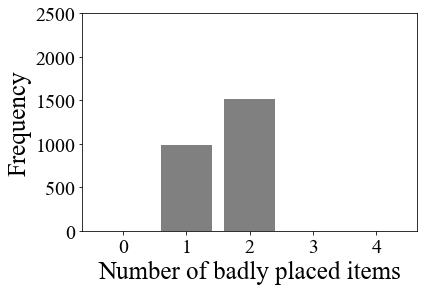

In [12]:
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()
# データ
categories = [0, 1, 2, 3, 4]
values = [0,
987,
1513,
0,
0
]

plt.figure(facecolor='white')

# 棒グラフをプロット
plt.bar(categories, values, color = 'gray')

# グラフのタイトルとラベル

plt.xlabel("Number of badly placed items", fontsize = 25, fontname = "Times New Roman")
plt.ylabel("Frequency", fontsize = 25, fontname = "Times New Roman")
plt.xticks(fontsize = 20, fontname = "Times New Roman")
plt.yticks(fontsize = 20, fontname = "Times New Roman")

plt.ylim(0,2500)

# グラフを表示
plt.show()

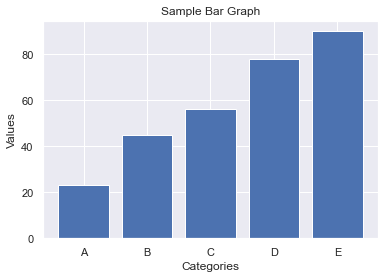

In [18]:
import matplotlib.pyplot as plt

# データ
categories = ['A', 'B', 'C', 'D', 'E']
values = [23, 45, 56, 78, 90]

# 棒グラフをプロット
plt.bar(range(len(categories)), values)

# X軸のラベルと目盛り
plt.xticks(range(len(categories)), categories)

# グラフのタイトルとラベル
plt.title('Sample Bar Graph')
plt.xlabel('Categories')
plt.ylabel('Values')

# グラフを表示
plt.show()

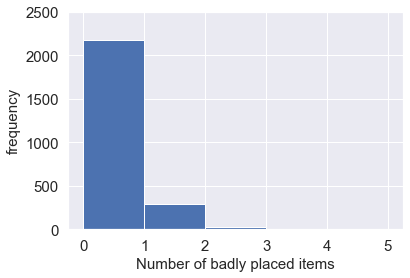

In [13]:
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
plt.hist(penalty_cvar, bins = range(6), range=(0, 5), align='mid')
plt.xlabel("Number of badly placed items", fontsize=15)
plt.ylabel("frequency", fontsize = 15)
plt.xticks(range(6), fontsize=15)
plt.yticks(fontsize = 15)
plt.ylim(0,2500)
plt.show()

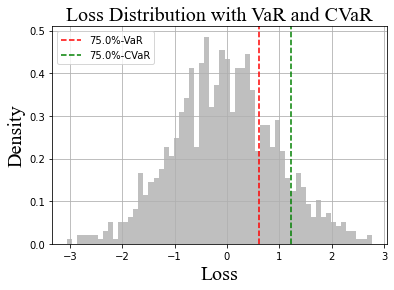

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# ランダムなリスク分布を生成（例として正規分布を使用）
np.random.seed(0)
losses = np.random.normal(loc=0, scale=1, size=1000)

# パーセンタイルを使用して VaR を計算
alpha = 0.75  # パーセンタイルの設定（例：75%）
var = np.percentile(losses, alpha * 100)

# VaR よりも大きい損失を抽出して CVaR を計算
cvar = np.mean(losses[losses > var])

# ヒストグラムをプロット
plt.hist(losses, bins=60, density=True, alpha=0.5, color='gray')

# VaR と CVaR をプロット
plt.axvline(x=var, color='r', linestyle='--', label=f'{alpha*100:.1f}%-VaR')
plt.axvline(x=cvar, color='g', linestyle='--', label=f'{alpha*100:.1f}%-CVaR')

# グラフの装飾
plt.title('Loss Distribution with VaR and CVaR', fontsize = 20, fontname = "Times New Roman")
plt.xlabel('Loss', fontsize = 20, fontname = "Times New Roman")
plt.ylabel('Density', fontsize = 20, fontname = "Times New Roman")
plt.legend()
plt.grid(True)

# グラフを表示
plt.show()